# A3

In [240]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import Network as Network
import copy
from IPython.display import Image
from IPython.core.display import HTML 


# Q1: Vanishing Gradient

## (a)

link:


## (b)

Your answer here.

## (c) Plots

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


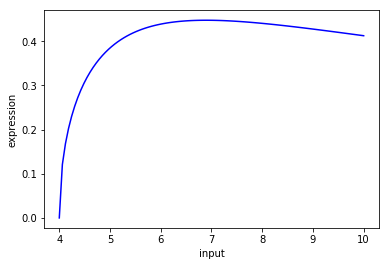

In [244]:
# === YOUR CODE HERE ===
def drawExpression(w):
    return 2/abs(w)* np.log(abs(w)/2 *(1+ np.sqrt(1-4/abs(w))) -1)
data = drawExpression(np.linspace(-10, -4, 100))
data1 = np.linspace(4, 10, 100)
dataY=drawExpression(data)
data1Y=drawExpression(data1)
plt.plot(data, dataY, 'blue')
plt.plot(data1, data1Y, 'blue')
plt.xlabel('input')
plt.ylabel('expression')
plt.show()

# Q2: Dropout

## Dataset

In [222]:
def GenerateDatasets(n):
    # 1D -> 1D (line mapping)
    n_input = 1
    n_output = 1
    noise = 0.5

    #np.random.seed(452)
    a = np.random.rand()/2.
    m = np.random.rand() + 0.5
    b = np.random.rand()-0.5

    def myfunc(x):
        return a*x**2 + m*x + b

    # Create a training dataset
    n_samples = n
    training_output = []
    training_input = []
    xv = np.linspace(-1, 1, n_samples)
    for idx in range(n_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx]
        t = myfunc(x) + np.random.normal(scale=noise)
        training_input.append(np.array([x]))
        training_output.append(np.array([t]))

    # Create a testing dataset
    test_input = []
    test_output = []
    n_test_samples = 300
    xv = np.linspace(-1, 1, n_test_samples)
    for idx in range(n_test_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx] #+ np.random.normal(scale=0.1)
        t = myfunc(x) + np.random.normal(scale=noise)
        test_input.append(np.array([x]))
        test_output.append(np.array([t]))


    train = [np.array(training_input), np.array(training_output)]
    test = [np.array(test_input), np.array(test_output)]
    
    return train, test

## Sample Code

In [223]:
# Here is an example, creating a Network object.
net = Network.Network(cost='cross-entropy')
net.AddLayer(Network.Layer(1))
net.AddLayer(Network.Layer(6, act='logistic'))
net.AddLayer(Network.Layer(1, act='logistic'))

In [224]:
# Generate the training and testing datasets
P = 5
train, test = GenerateDatasets(P)

In [225]:
# Train the network
progress = net.SGD(train[0], train[1], epochs=100, lrate=1.)

In [226]:
# Evaluate the cost 
print('Training cost = '+str(net.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net.Evaluate(test[0], test[1])))

# These results won't necessarily make sense, since the network model
# might not be the right choice for the dataset.

Training cost = 0.06967678711987028
    Test cost = -0.21891759892426146


## 2 (a), (b), 3 (a) Completing the RobustNetwork Class

In [227]:
class RobustNetwork(Network.Network):
    
    def FeedForward(self, x, dropout=0):
        '''
            y = net.FeedForward(x, dropout=0)

            Runs the network forward, starting with x as input.
            However, a random subset of the hidden nodes are set to 0 activity.
            Returns the activity of the output layer.

            Inputs:
              x is a batch of inputs
              dropout is a probability that a node is dropped, in [0,1]
              
            Outputs:
              y is the batch of outputs (no dropout or the output layer)
        '''
        if dropout==0.:
            self.dropout_nonzero = False  # Internal flag for dropout
            super(RobustNetwork, self).FeedForward(x)
        else:
            self.dropout_nonzero = True   # Internal flag for dropout
            
            currLayer=0;
            x = np.array(x)  # Convert input to array, in case it's not
            
            self.lyr[0].h = x # Set input layer
            
            self.mask = []  # mask will record which nodes were dropped
            self.mask.append(None)  # Input layer does not have dropout
    
            # Loop over connections
            for pre,post,W in zip(self.lyr[:-1], self.lyr[1:], self.W):
                
                # Calc. input current to next layer
                post.z = pre.h @ W + post.b
                # Use activation function to get activities
                post.h = post.sigma(post.z)
            
                maxLayer = self.n_layers-2
                if currLayer != maxLayer:
                    numberofNodes = post.N
                    npSeries = np.arange(numberofNodes)
                    np.random.shuffle(npSeries)
                    for i in range(numberofNodes):
                        if npSeries[i] < (numberofNodes * dropout):
                            npSeries[i]=0
                        else:
                            npSeries[i]=1
                    remaining = 1- dropout
                    npSeries= npSeries/remaining
                    post.h*= npSeries
                    # update mask 
                    self.mask.append(npSeries)
                currLayer=currLayer+1
        # Return activity of output layer
        return self.lyr[-1].h
    
    
    
    def BackProp(self, t, lrate=0.05, decay=0.):
        '''
            net.BackProp(targets, lrate=0.05)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
             decay  is the coefficient for weight/bias decay
        '''
        t = np.array(t)  # convert t to an array, in case it's not
        
        # Error gradient for top layer
        dEdz = self.TopGradient(t)
        
        # Loop down through the layers
        for i in range(self.n_layers-2, -1, -1):
            ithWeight=self.W[i]
            pre = self.lyr[i]
            
            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz + 2*decay*ithWeight
            
            # Gradient w.r.t. biases
            dEdb = np.sum(dEdz, axis=0)
            
            # Project error gradient down to layer below.
            if ((i>0)and(self.dropout_nonzero)):
                dEdz = ( dEdz @ self.W[i].T ) * self.mask[i] * pre.sigma_z_p(pre.z)
            
            # Update weights and biases
            self.W[i] -= lrate*dEdW
            self.lyr[i+1].b -= lrate*dEdb
    
    
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10, decay=0, dropout=0):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, decay=0, dropout=0)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it
            shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              decay   is the decay coefficient for the weights and biases
              dropout is the dropout probability
              
            Outputs:
              progress is an (expochs)x2 array with epoch in the first column, and 
                      cost in the second column
        '''
        loss_history = []
        for k in range(epochs):
            batches = Network.MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0], dropout=dropout)
                self.BackProp(mini_batch[1], decay=decay)

            loss_history.append([k, self.Evaluate(inputs, targets)])

        return np.array(loss_history)


## (c) Create the Network

In [228]:
# === YOUR CODE HERE ===
original_net=RobustNetwork("MSE")
# one input node
original_net.AddLayer(Network.Layer(1))
# hidden layer with 10 nodes
original_net.AddLayer(Network.Layer(10, "arctan"))
#output node
original_net.AddLayer(Network.Layer(1, "identity"))
# make a copy 
dropout_net = copy.deepcopy(original_net)

## (d) Train and Evaluate without dropout

In [229]:
# === YOUR CODE HERE ===
# Generate the training and testing datasets
P = 5
train, test = GenerateDatasets(P)
# Train the network
progress = original_net.SGD(train[0], train[1], lrate=1, epochs=5000,batch_size=5,dropout=0)
inputs = train[0]
targets= train[1]
averageLossTrainingSet = original_net.Evaluate(inputs, targets)
inputs= test[0]
targets=test[1]
averageLossTestingSet = original_net.Evaluate(inputs, targets)
print("averageLossTrainingSet" + " " + str(averageLossTrainingSet) + "\n")
print("averageLossTestingSet" + " " + str(averageLossTestingSet) + "\n")

averageLossTrainingSet 0.008972915179234774

averageLossTestingSet 0.34208055018034933



## (e) Train and Evaluate with dropout

In [230]:
loss_history = dropout_net.SGD(train[0], train[1], lrate=1, epochs=5000, batch_size=5, dropout=0.2)
print("loss_history: ") 
print(loss_history)
print("Training Set \n" + "MSE: " + str(dropout_net.Evaluate(train[0], train[1])))
print("Test Set \n" + "MSE: " + str(dropout_net.Evaluate(test[0], test[1])))

loss_history: 
[[0.00000000e+00 1.53244269e+00]
 [1.00000000e+00 1.02142781e+00]
 [2.00000000e+00 8.10841591e-01]
 ...
 [4.99700000e+03 2.43332506e-01]
 [4.99800000e+03 2.43390415e-01]
 [4.99900000e+03 2.43586368e-01]]
Training Set 
MSE: 0.24358636814501175
Test Set 
MSE: 0.2784265363989376


## (f) Plot training data and models

Text(0, 0.5, 'outputs')

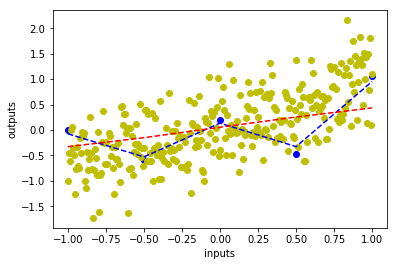

In [231]:
# === YOUR CODE HERE ===
plt.plot(train[0], train[1], "bo")
plt.plot(test[0], test[1], "yo")
plt.plot(train[0], original_net.FeedForward(train[0]), "b--")
plt.plot(train[0], dropout_net.FeedForward(train[0], 0.2), "r--")
plt.xlabel("inputs") 
plt.ylabel("outputs") 

## (g) Average performance over 10 datasets

In [232]:
# === YOUR CODE HERE ===
arr = np.zeros((10, 3))
# each [] store the # orgin_net_cost, dropout_net_cost

i = 0
originalCost=[]
dropoutCost=[]
for i in range(10):
    list =[]
    # step 1
    original_net=RobustNetwork("MSE")
    # one input node
    original_net.AddLayer(Network.Layer(1))
    # hidden layer with 10 nodes
    original_net.AddLayer(Network.Layer(10, "arctan"))
    #output node
    original_net.AddLayer(Network.Layer(1, "identity"))
    # make a copy 
    dropout_net = copy.deepcopy(original_net)
    # step 2
    trainDataset, testDataset = GenerateDatasets(5)
    # setp 2, trin one with without/with dropout
    original_net.SGD(trainDataset[0], trainDataset[1], lrate=1, epochs=5000, batch_size=5)
    dropout_net.SGD(trainDataset[0], trainDataset[1], lrate=1, epochs=5000, batch_size=5, dropout=0.2)
    list.append(i)
    list.append(original_net.Evaluate(test[0], test[1]))
    list.append(dropout_net.Evaluate(test2[0], test2[1]))
    originalCost.append(list[1])
    dropoutCost.append(list[2])
    print("trial #" + str(list[0]) + " without dropout cost= " + str(list[1]) + " with dropoutcost= " + str(list[2]) + '\n')
    
print("mean cost without dropout 10 times = " + str(sum(originalCost)/10) +'\n')
print("mean cost with dropout 10 times = " + str(sum(dropoutCost)/10) +'\n')


trial #0 without dropout cost= 0.34026542855895087 with dropoutcost= 0.3182917478079146

trial #1 without dropout cost= 0.6164536634622393 with dropoutcost= 0.5413131204103614

trial #2 without dropout cost= 0.2756753714500441 with dropoutcost= 0.3060349398880884

trial #3 without dropout cost= 0.46702207219064745 with dropoutcost= 0.48439378854702786

trial #4 without dropout cost= 0.294196971823766 with dropoutcost= 0.35290528124818565

trial #5 without dropout cost= 0.38195424462121075 with dropoutcost= 0.43413661738606835

trial #6 without dropout cost= 0.36402451451014545 with dropoutcost= 0.43036788928114805

trial #7 without dropout cost= 0.38922057008577243 with dropoutcost= 0.4198318993090322

trial #8 without dropout cost= 0.5253199385894836 with dropoutcost= 0.6932998204931228

trial #9 without dropout cost= 0.44854538152060314 with dropoutcost= 0.4355311048588565

mean cost without dropout 10 times = 0.41026781568128634

mean cost with dropout 10 times = 0.4416106209229806


I prefer dropout model, since the mean cost of dropout is relative smaller and it prevent over-fitting


# Q3: Weight Decay

## (a) Implement weigth decay in BackProp (see code above)

## (b) Average performance over 10 datasets

In [233]:
# === YOUR CODE HERE ===
# === YOUR CODE HERE ===
arr = np.zeros((10, 3))
# each [] store the # orgin_net_cost, dropout_net_cost

i = 0
originalCost=[]
decayCost=[]
for i in range(10):
    list =[]
    # step 1
    original_net=RobustNetwork("MSE")
    # one input node
    original_net.AddLayer(Network.Layer(1))
    # hidden layer with 10 nodes
    original_net.AddLayer(Network.Layer(10, "arctan"))
    #output node
    original_net.AddLayer(Network.Layer(1, "identity"))
    # make a copy 
    decay_net = copy.deepcopy(original_net)
    # step 2
    trainDataset, testDataset = GenerateDatasets(5)
    # setp 2, trin one with without/with dropout
    original_net.SGD(trainDataset[0], trainDataset[1], lrate=1, epochs=5000, batch_size=5)
    decay_net.SGD(trainDataset[0], trainDataset[1], lrate=1, epochs=5000, batch_size=5, dropout=0.2)
    list.append(i)
    list.append(original_net.Evaluate(test[0], test[1]))
    list.append(dropout_net.Evaluate(test2[0], test2[1]))
    originalCost.append(list[1])
    decayCost.append(list[2])
    print("trial #" + str(list[0]) + " original cost= " + str(list[1]) + " with decay cost= " + str(list[2]) + '\n')
    
print("mean cost of original 10 times = " + str(sum(originalCost)/10) +'\n')
print("mean cost with decay 10 times = " + str(sum(decayCost)/10) +'\n')


trial #0 original cost= 1.2528585857588868 with decay cost= 0.4355311048588565

trial #1 original cost= 0.2849858296682092 with decay cost= 0.4355311048588565

trial #2 original cost= 0.38036033052220103 with decay cost= 0.4355311048588565

trial #3 original cost= 0.270776884319786 with decay cost= 0.4355311048588565

trial #4 original cost= 0.45367712024017653 with decay cost= 0.4355311048588565

trial #5 original cost= 0.2632693527072921 with decay cost= 0.4355311048588565

trial #6 original cost= 0.3356442432193026 with decay cost= 0.4355311048588565

trial #7 original cost= 0.5168098582634771 with decay cost= 0.4355311048588565

trial #8 original cost= 0.38591905972715973 with decay cost= 0.4355311048588565

trial #9 original cost= 0.7422177972147007 with decay cost= 0.4355311048588565

mean cost of original 10 times = 0.48865190616411913

mean cost with decay 10 times = 0.4355311048588565



I prefer dacay model. Since it has less cose as compared to original one which bascially means we hava a better performace

# Q4: Classifier Networks

## Create and interesting dataset

In [234]:
def ClassPlot(x, y):
    # FeedForward
    yc = Network.OneHot(y)
    colour_options = ['y', 'b', 'r', 'g', 'k']
    cidx = np.argmax(yc, axis=1)
    colours = [colour_options[k] for k in cidx]
    plt.scatter(x[:,0],x[:,1], color=colours, marker='.')
    plt.axis('equal');

def GaussianCluster(mu, sa, N, theta=0.):
    theta_rad = theta/180*np.pi
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    R = np.array([[c,-s],[s,c]])
    M = R @ np.diag(sa) @ R.T
    y = np.random.multivariate_normal(mu, M, N)
    return y

def CreateDataset(params):
    '''
        train, test = CreateDataset(params)
        
        Creates a dataset using a bunch of Gaussian clouds.
        
        Inputs:
          params is a list of 5-tuples. Each tuple (or list)
             describes a 2-D Gaussian cloud:
             1) the mean
             2) standard deviation along x and y directions
             3) rotation of cloud (degrees counter-clockwise)
             4) class index
             5) number of points
             
        Outputs:
          train is a list containing 2 arrays
             - the first array contains the training inputs,
               one per row
             - the second array contains the corresponding classes
          test has the same structure as train, but with
               half the number of samples
    '''
    train_inputs = []
    train_outputs = []
    test_inputs = []
    test_outputs = []
    all_c = [p[3] for p in params]
    n_classes = np.max(all_c)
    for p in params:
        xx = GaussianCluster(p[0], p[1], p[4], theta=p[2])
        yy = np.zeros((p[4], n_classes+1))
        yy[:,p[3]] = 1.
        train_inputs.append(xx)
        train_outputs.append(yy)
        xtest = GaussianCluster(p[0], p[1], int(p[4]/2), theta=p[2])
        ytest = np.zeros((int(p[4]/2), n_classes+1))
        ytest[:,p[3]] = 1.
        test_inputs.append(xtest)
        test_outputs.append(ytest)
    train = [np.vstack(train_inputs), np.vstack(train_outputs)]
    test = [np.vstack(test_inputs), np.vstack(test_outputs)]
    return train, test

# 0=y, 1=b, 2=r
params = [[[0.5, 0.5],   [0.025, 0.01],  -45, 0, 50],
          [[-0.5,-0.5],  [0.025, 0.01],  -45, 0, 50],
          [[-0.3,-0.35], [0.04,0.01],     10, 0, 80],
          [[0.6,0],      [0.01,0.01],      0, 0, 50],
          [[0.1,-0.04],  [0.1,0.005],     20, 0, 80],
          [[0.5,-0.5],   [0.02,0.01],     45, 1, 50],
          [[0,0.6],      [0.01,0.01],      0, 1, 50],
          [[-0.5,0.1],   [0.02,0.01],     30, 1, 80],
          [[-0.5,0.5],   [0.02,0.01],     45, 2, 50],
          [[0,-0.6],     [0.01,0.01],      0, 2, 50],
          [[0.2,0.3],    [0.01,0.004],     0, 2, 80],
          [[-0.2,0.37],  [0.02,0.005],   -30, 2, 50],
          [[0.25,-0.3],  [0.005,0.01],     0, 3, 60],
          [[-0.1,0.1],   [0.01,0.01],    -30, 3, 50]
         ]

In [235]:
train, test = CreateDataset(params)

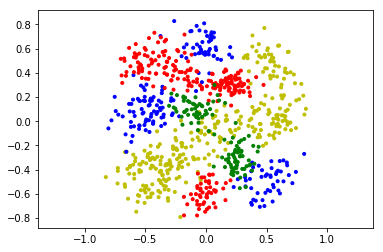

In [236]:
ClassPlot(train[0], train[1]);

## (a) Create and Evaluate a Neural Network

In [237]:
# === YOUR CODE HERE ===

## (b) Evaluate Model

In [238]:
# === YOUR CODE HERE ===

## (c) Crappy Network

In [239]:
# === YOUR CODE HERE ===